#Imports and functions

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import random
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import scipy

from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import power_transform
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, make_scorer, roc_auc_score, confusion_matrix, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
import statsmodels.api as sm

plt.rcParams['figure.figsize'] = 10, 7
plt.style.use('bmh')

%config InlineBackend.figure_format = 'svg'

In [ ]:
#input: pd.DataFrame
#output: lower_limit: Series([], dtype: float64), upper_limit: Series([], dtype: float64)
#summary: finds limits of provided data using IQR
def find_limits(data):
  Q1 = data.quantile(0.25)
  Q3 = data.quantile(0.75)
  IQR = Q3 - Q1

  lower_limit = Q1 - 1.5 * IQR
  upper_limit = Q3 + 1.5 * IQR

  return lower_limit, upper_limit


#input: data: pd.DataFrame, lower_limit: Series([], dtype: float64), upper_limit: Series([], dtype: float64)
#output: int
#summary: finds number of outliers of provided data using limits
def count_outliers(data, lower_limit, upper_limit):
  return len(data[data > upper_limit] + data[data < lower_limit])


#input: data: pd.DataFrame, lower_limit: Series([], dtype: float64), upper_limit: Series([], dtype: float64)
#summary: plots data distribution with limit lines
def create_hist_with_outliers(data, lower_limit, upper_limit):
  sns.distplot(x=data, axlabel=data.name).set(title=f'{data.name} distribution')
  plt.axvline(upper_limit, linewidth=1 , color = 'red')
  plt.axvline(lower_limit, linewidth=1 , color = 'red')
  plt.show()

In [ ]:
#input: model: estimator object; param: dict or list of dictionaries,
#       cv: int; cross-validation generator or an iterable,
#       X: array-like of shape (n_samples, n_features); y: array-like of shape (n_samples, n_output) or (n_samples,)
#summary: finds best model parameters using grid search
def grid_search(model, param, cv, X, y):
  clf = GridSearchCV(model,param,scoring='f1_weighted',refit=True,cv=cv, error_score='raise')
  clf.fit(X,y)
  print('Best f1: {}, with best: {}'.format(clf.best_score_, clf.best_params_))


#input: data: pd.DataFrame, classes: int
#output: np.array with (len(data), classes) shape
#summary: creates matrix of binary flags, which indicates a row belongs to a class
def make_binary_labels_matrix(data, classes):
    result = np.zeros((len(data), classes))
    for i in range(len(data)):
        result[i][data[i]] = 1
    return result


#input: model:estimator object; X_train: array-like of shape (n_samples, n_features);
#       y_train: array-like of shape (n_samples, n_output) or (n_samples,);
#       X_test: array-like of shape (n_samples, n_features);
#       y_test: array-like of shape (n_samples, n_output) or (n_samples,); n_splits: int
#output: list of cv scores
#summary: train model usind StratifiedKFold for cross-validation
def build_model_with_cv(model, X_train, y_train, X_test, y_test, n_splits):
  kf = StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=18)
  pred_test_full = 0
  cv_score = []
  i=1

  for train_index,test_index in kf.split(X_train,y_train):
      print('{} of KFold {}'.format(i,kf.n_splits))
      xtr,xvl = X_train.loc[train_index],X_train.loc[test_index]
      ytr,yvl = y_train.loc[train_index],y_train.loc[test_index]

      model.fit(xtr,ytr)

      ypr = model.predict(xvl)

      classes = yvl[0].unique().size
      yvlmat = make_binary_labels_matrix(yvl[0].to_numpy().reshape(-1), classes)
      yprmat = make_binary_labels_matrix(ypr, classes)

      score = f1_score(yvlmat, yprmat, average='weighted')
      print('F1 weighted score:',score)
      cv_score.append(score)
      pred_test = model.predict_proba(X_test)[:,1]
      pred_test_full += pred_test
      i+=1

  return cv_score

In [ ]:
#input: y: array-like of shape (n_samples, n_classes), y_pred: array-like of shape (n_samples, n_classes)
#summary: prints confusion matrix
def print_confusion_matrix(y, y_pred):
  cf_matrix = confusion_matrix(y,y_pred)
  sns.heatmap(cf_matrix,
            annot = cf_matrix / np.sum(cf_matrix, axis=1), #normalized by true class sizes
  )
  plt.show()


#input: model: estimator object; X: array-like of shape (n_samples, n_features);
#       y: array-like of shape (n_samples, n_output) or (n_samples,); cv_score: list
#summary: tests model and prints results
def print_results(model, X, y, cv_score):
  y_pred = model.predict(X)
  print('Cv:', cv_score, '\nMean cv Score:', np.mean(cv_score))
  print_confusion_matrix(y, y_pred)
  print('Score:', model.score(X, y))
  print("----------------------------------------------------------")
  print(classification_report(y,y_pred))

#EDA and Data preparation

In [ ]:
df = pd.read_csv('/content/dataset_57_hypothyroid.csv')
df.head()

age sex on_thyroxine query_on_thyroxine on_antithyroid_medication sick  \
0  41   F            f                  f                         f    f   
1  23   F            f                  f                         f    f   
2  46   M            f                  f                         f    f   
3  70   F            t                  f                         f    f   
4  70   F            f                  f                         f    f   

  pregnant thyroid_surgery I131_treatment query_hypothyroid  ... TT4_measured  \
0        f               f              f                 f  ...            t   
1        f               f              f                 f  ...            t   
2        f               f              f                 f  ...            t   
3        f               f              f                 f  ...            t   
4        f               f              f                 f  ...            t   

   TT4 T4U_measured   T4U FTI_measured  FTI TBG_measured TBG referral_source  \
0  125            t  1.14            t  109            f   ?            SVHC   
1  102            f     ?            f    ?            f   ?           other   
2  109            t  0.91            t  120            f   ?           other   
3  175            f     ?            f    ?            f   ?           other   
4   61            t  0.87            t   70            f   ?             SVI   

      Class  
0  negative  
1  negative  
2  negative  
3  negative  
4  negative  

[5 rows x 30 columns]

In [ ]:
df.shape

(3772, 30)

There are 3772 records and 30 features.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3772 non-null   object
 1   sex                        3772 non-null   object
 2   on_thyroxine               3772 non-null   object
 3   query_on_thyroxine         3772 non-null   object
 4   on_antithyroid_medication  3772 non-null   object
 5   sick                       3772 non-null   object
 6   pregnant                   3772 non-null   object
 7   thyroid_surgery            3772 non-null   object
 8   I131_treatment             3772 non-null   object
 9   query_hypothyroid          3772 non-null   object
 10  query_hyperthyroid         3772 non-null   object
 11  lithium                    3772 non-null   object
 12  goitre                     3772 non-null   object
 13  tumor                      3772 non-null   object
 14  hypopitu

All features have dtype object. We'll convert some features later for future work.

Let's check if there are any missing values.

In [ ]:
df.isnull().sum()

age                          0
sex                          0
on_thyroxine                 0
query_on_thyroxine           0
on_antithyroid_medication    0
sick                         0
pregnant                     0
thyroid_surgery              0
I131_treatment               0
query_hypothyroid            0
query_hyperthyroid           0
lithium                      0
goitre                       0
tumor                        0
hypopituitary                0
psych                        0
TSH_measured                 0
TSH                          0
T3_measured                  0
T3                           0
TT4_measured                 0
TT4                          0
T4U_measured                 0
T4U                          0
FTI_measured                 0
FTI                          0
TBG_measured                 0
TBG                          0
referral_source              0
Class                        0
dtype: int64

In [ ]:
df.describe().T

count unique       top  freq
age                        3772     94        59    95
sex                        3772      3         F  2480
on_thyroxine               3772      2         f  3308
query_on_thyroxine         3772      2         f  3722
on_antithyroid_medication  3772      2         f  3729
sick                       3772      2         f  3625
pregnant                   3772      2         f  3719
thyroid_surgery            3772      2         f  3719
I131_treatment             3772      2         f  3713
query_hypothyroid          3772      2         f  3538
query_hyperthyroid         3772      2         f  3535
lithium                    3772      2         f  3754
goitre                     3772      2         f  3738
tumor                      3772      2         f  3676
hypopituitary              3772      2         f  3771
psych                      3772      2         f  3588
TSH_measured               3772      2         t  3403
TSH                        3772    288         ?   369
T3_measured                3772      2         t  3003
T3                         3772     70         ?   769
TT4_measured               3772      2         t  3541
TT4                        3772    242         ?   231
T4U_measured               3772      2         t  3385
T4U                        3772    147         ?   387
FTI_measured               3772      2         t  3387
FTI                        3772    235         ?   385
TBG_measured               3772      1         f  3772
TBG                        3772      1         ?  3772
referral_source            3772      5     other  2201
Class                      3772      4  negative  3481

Missing values seem to be marked as "?". Let's replace them with NaNs.

In [ ]:
df=df.replace({"?":np.NaN})

In [ ]:
df.isnull().sum()

age                             1
sex                           150
on_thyroxine                    0
query_on_thyroxine              0
on_antithyroid_medication       0
sick                            0
pregnant                        0
thyroid_surgery                 0
I131_treatment                  0
query_hypothyroid               0
query_hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH_measured                    0
TSH                           369
T3_measured                     0
T3                            769
TT4_measured                    0
TT4                           231
T4U_measured                    0
T4U                           387
FTI_measured                    0
FTI                           385
TBG_measured                    0
TBG                          3772
referral_source                 0
Class         

The feature `TBG` has 0 non-null values so we can drop it.

In [ ]:
df.drop(['TBG'], axis=1 , inplace=True)

Features `TSH_measured`, `T3_measured`, `TT4_measured`, `FTI_measured`, `TBG_measured`, `T4U_measured` are not important for our research. They can only show where the missing values are in the features `TSH`, `T3`, `TT4`, `FTI`, `TBG` and `T4U` respectively. We can drop them. Also, as far as I understand, `referral_source` means the source of the provided data, so it might not be a good feature for our research, I'll remove it too.

In [ ]:
df.drop(['TSH_measured', 'T3_measured', 'TT4_measured', 'FTI_measured', 'TBG_measured', 'T4U_measured', 'referral_source'], axis=1 , inplace=True)

Let's define numeric and categorical features.

In [ ]:
df[['age','TSH', 'T3','TT4','T4U', 'FTI']] = df[['age','TSH', 'T3','TT4','T4U', 'FTI']].astype(float)

numeric_features = df.select_dtypes('number').columns
categorical_features = df.select_dtypes(np.object).columns.drop('Class')

In [ ]:
df.describe().T

count        mean        std    min    25%     50%     75%     max
age  3771.0   51.735879  20.084958  1.000  36.00   54.00   67.00  455.00
TSH  3403.0    5.086766  24.521470  0.005   0.50    1.40    2.70  530.00
T3   3003.0    2.013500   0.827434  0.050   1.60    2.00    2.40   10.60
TT4  3541.0  108.319345  35.604248  2.000  88.00  103.00  124.00  430.00
T4U  3385.0    0.995000   0.195457  0.250   0.88    0.98    1.08    2.32
FTI  3387.0  110.469649  33.089698  2.000  93.00  107.00  124.00  395.00

Some max values for hormone tests looks suspicious. We'll investigate with these later while dealing with outliers. The max value for `age` is 455. We'll deal with it after plotting feature distributions.

##Feature visualization

For numeric features, I'll plot the distribution and count the number of outliers.

age: lower limit: -10.5, upper limit: 113.5, outliers: 1


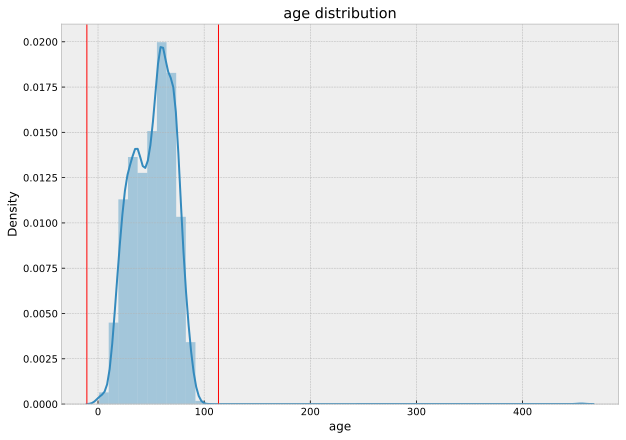

TSH: lower limit: -2.8000000000000003, upper limit: 6.0, outliers: 366


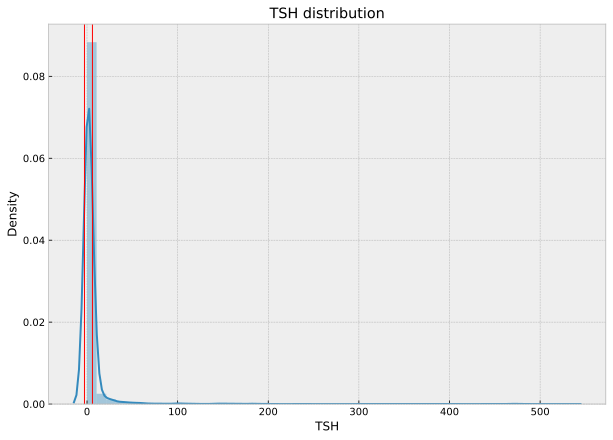

T3: lower limit: 0.40000000000000036, upper limit: 3.5999999999999996, outliers: 189


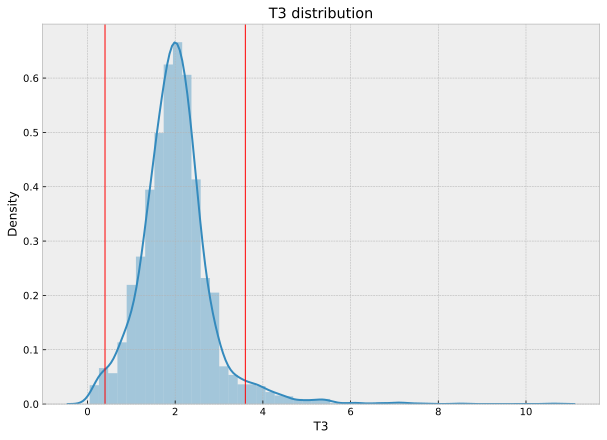

TT4: lower limit: 34.0, upper limit: 178.0, outliers: 193


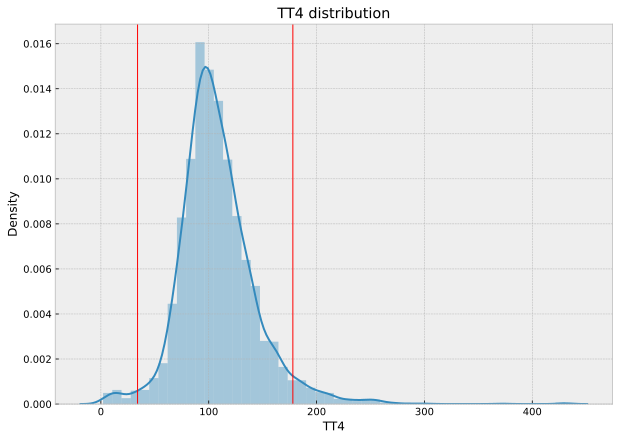

T4U: lower limit: 0.5799999999999998, upper limit: 1.3800000000000001, outliers: 168


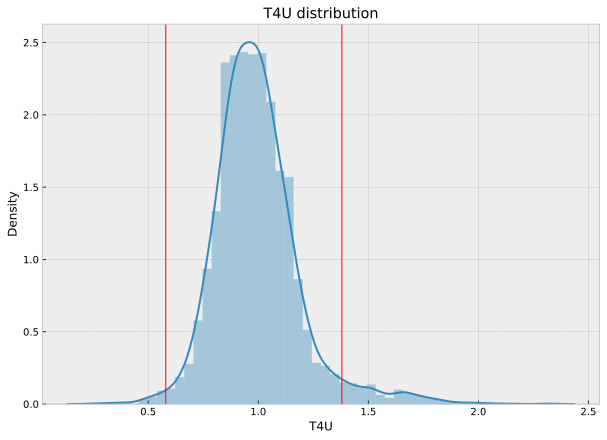

FTI: lower limit: 46.5, upper limit: 170.5, outliers: 212


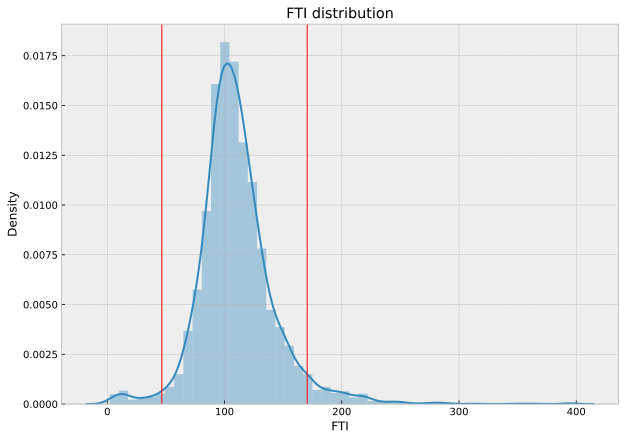

In [ ]:
for feature in numeric_features:
  lower_limit, upper_limit = find_limits(df[feature])
  print(f'{feature}: lower limit: {lower_limit}, upper limit: {upper_limit}, outliers: {count_outliers(df[feature], lower_limit, upper_limit)}')
  create_hist_with_outliers(df[feature], lower_limit, upper_limit)

We can see that most of the features have quite a large number of outliers. However, given our object of research, this type of variance is normal in this context and should be expected when dealing with tests involved in determination of the diagnosis.

Let's take a look at the age outlier.

In [ ]:
df[df.age > 113]

age sex on_thyroxine query_on_thyroxine on_antithyroid_medication  \
1364  455.0   F            f                  f                         f   

     sick pregnant thyroid_surgery I131_treatment query_hypothyroid  ...  \
1364    f        f               f              f                 f  ...   

     goitre tumor hypopituitary psych  TSH   T3    TT4   T4U    FTI     Class  
1364      f     f             f     f  1.1  2.0  118.0  1.13  104.0  negative  

[1 rows x 22 columns]

We'll replace its value with NaN.

In [ ]:
df['age'] = np.where((df.age > 113), np.NaN, df.age)

I'd like to look at the distribution of Hormone levels and age for each of our target classes.

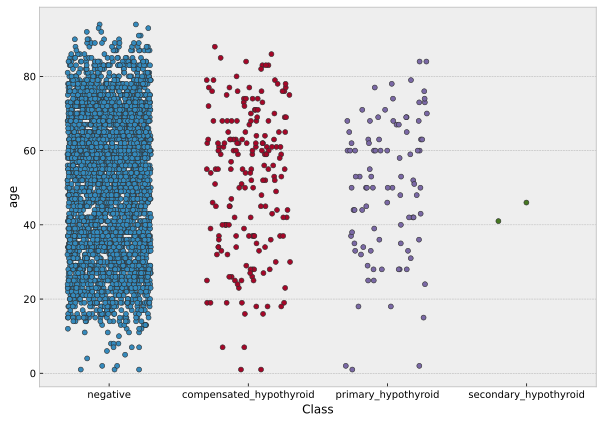

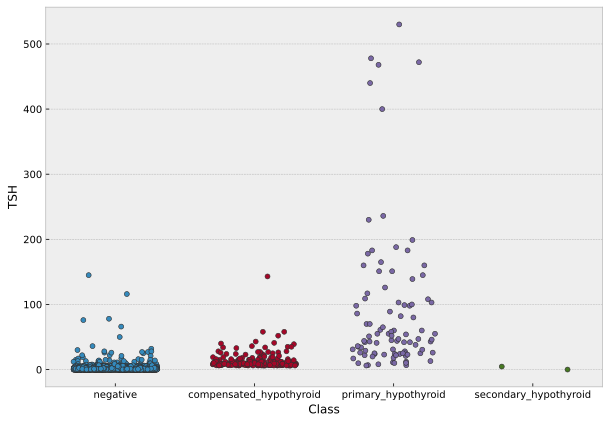

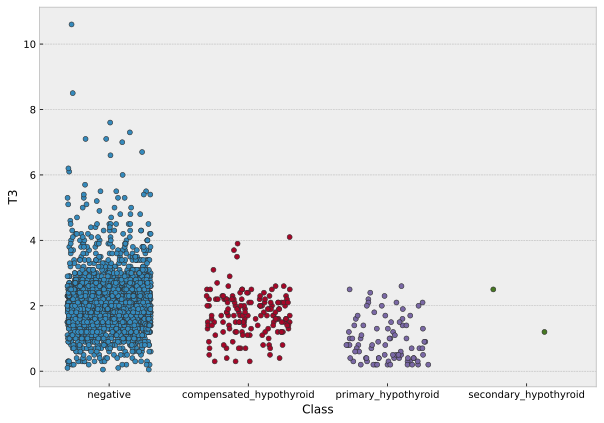

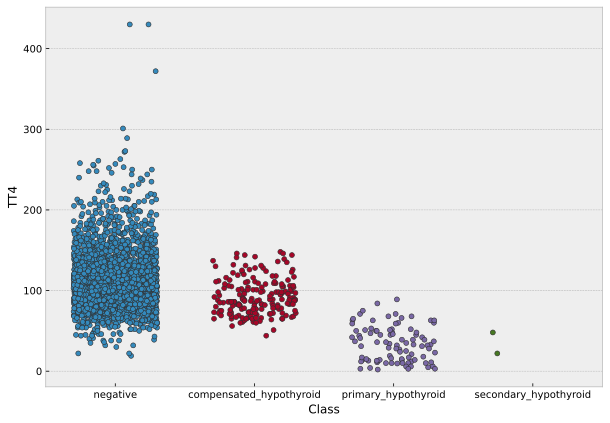

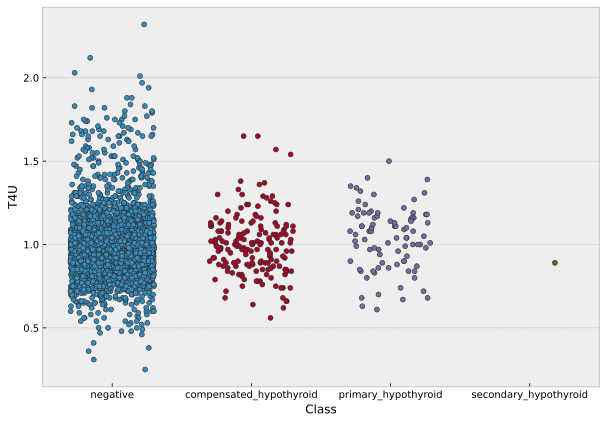

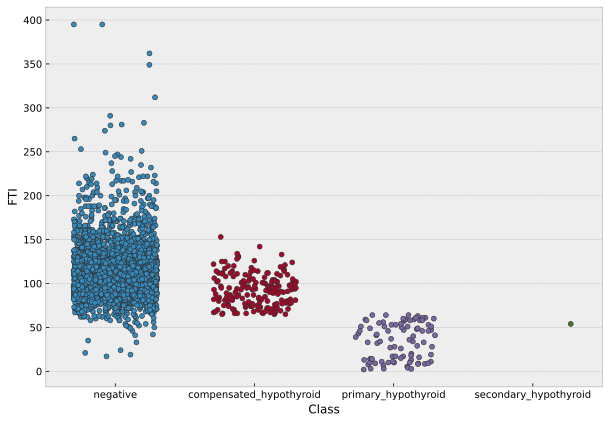

In [ ]:
for feature in numeric_features:
  sns.stripplot(x=df.Class, y=df[feature], linewidth=0.6, jitter= 0.3)
  plt.show()

We can assume that the `T3`, `TT4` and `FTI` will be good features for our models. It looks like `TSH` might be good too, but we need more analysis before making any decisions.

Let's make pairplots for these features.

In [ ]:
sns.pairplot(df, hue='Class', height=3);
plt.show()

Looking at the distributions, we can see our dataset is very unbalanced. Pairs "`age` vs `TT4`", "`age` vs `FTI`", "`T3` vs `TT4`", "`T3` vs `FTI`", "`TT4` vs `FTI`", "`T4U` vs `TT4`" and "`T4U` vs `FTI`" are better at separating target classes comparing to others.

Let's look at categorical features.

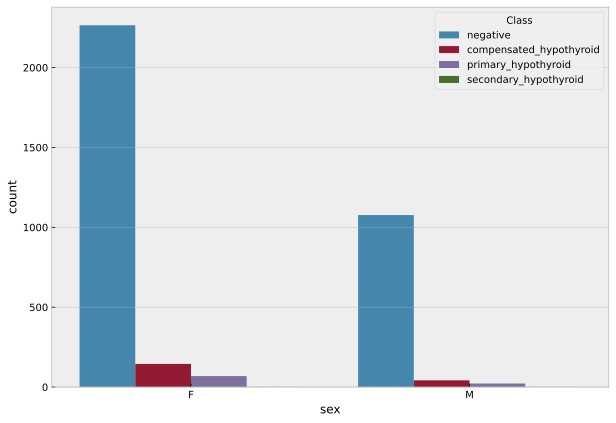

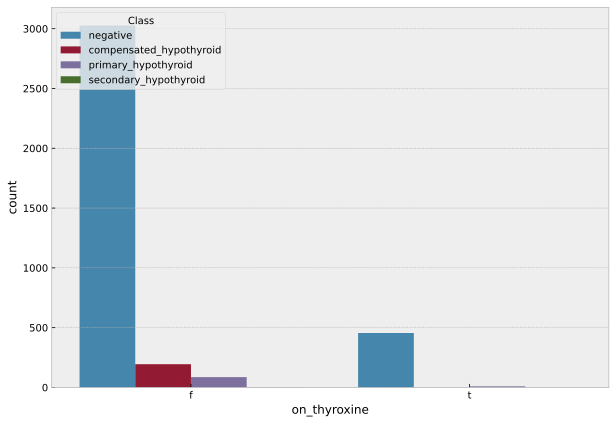

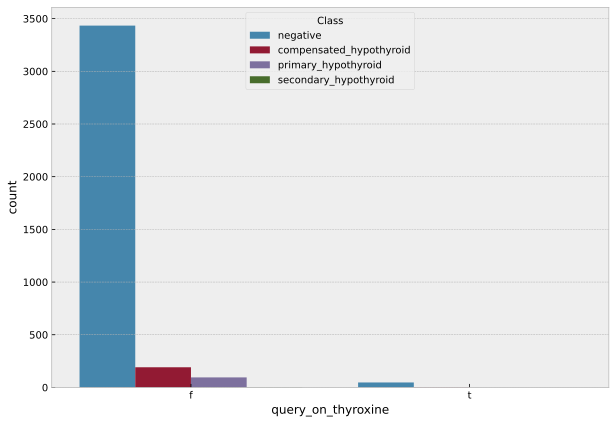

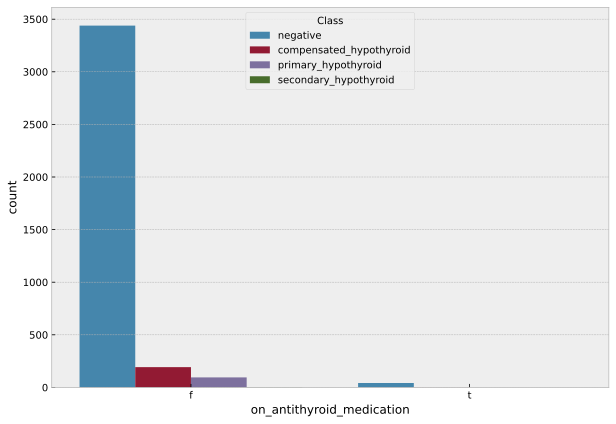

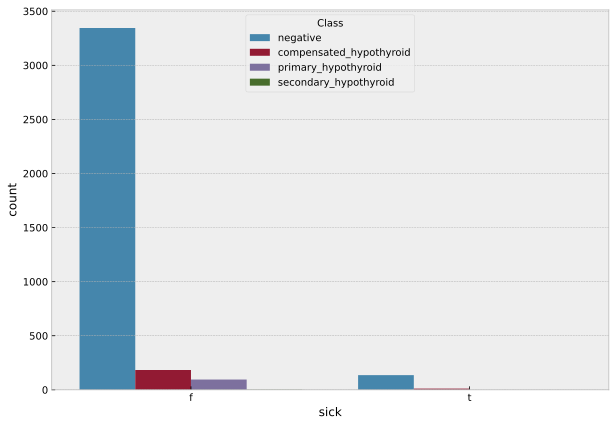

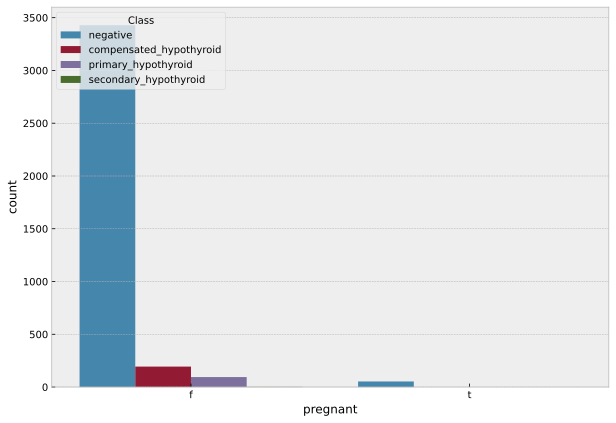

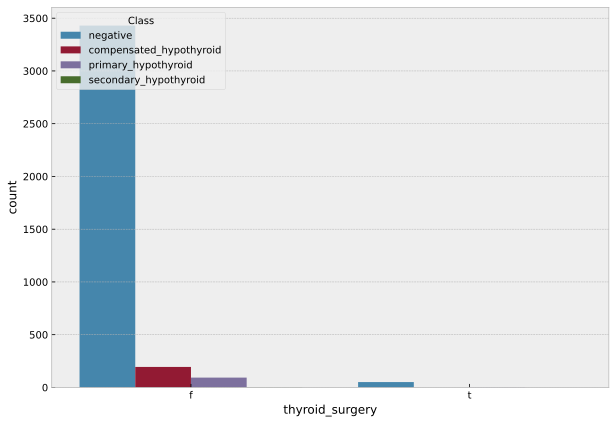

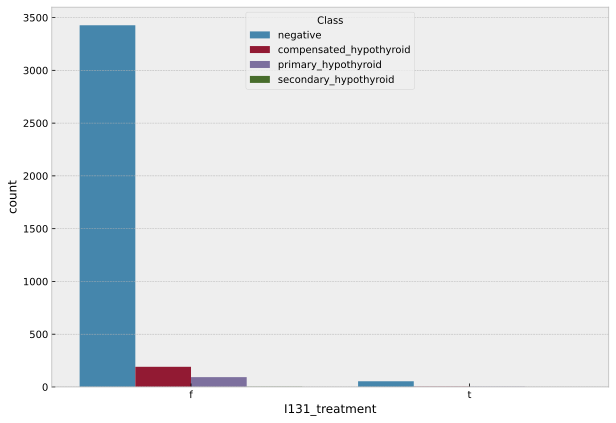

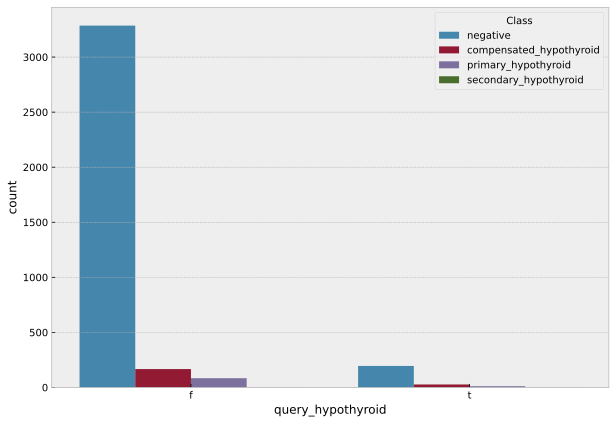

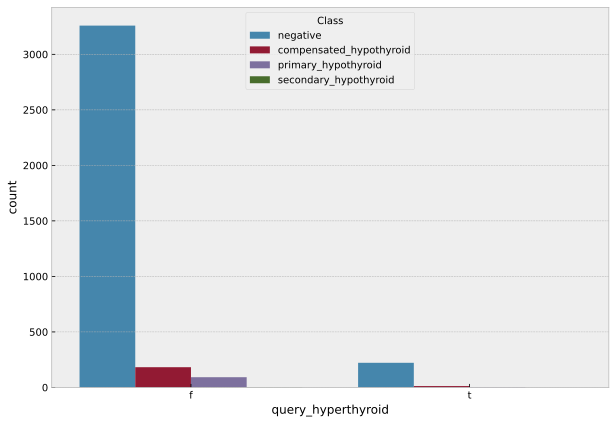

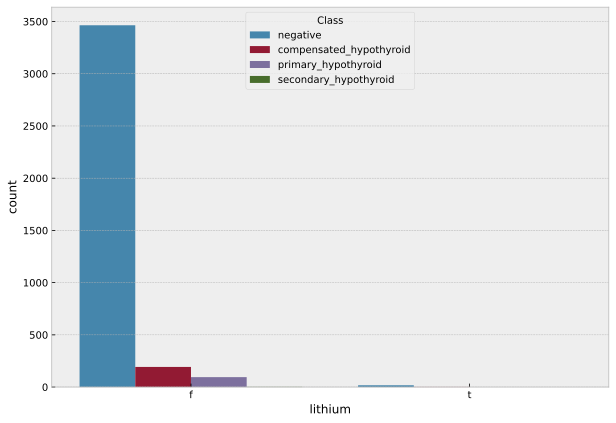

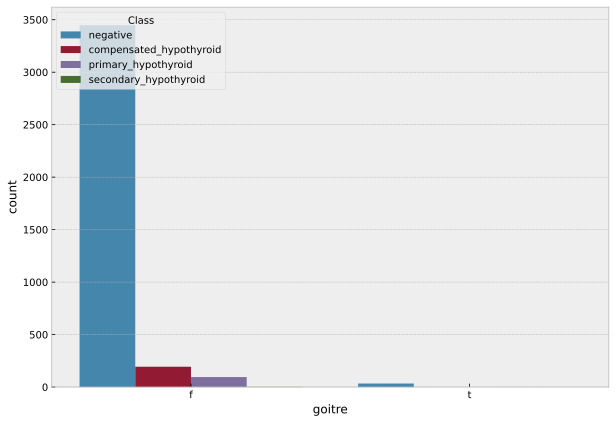

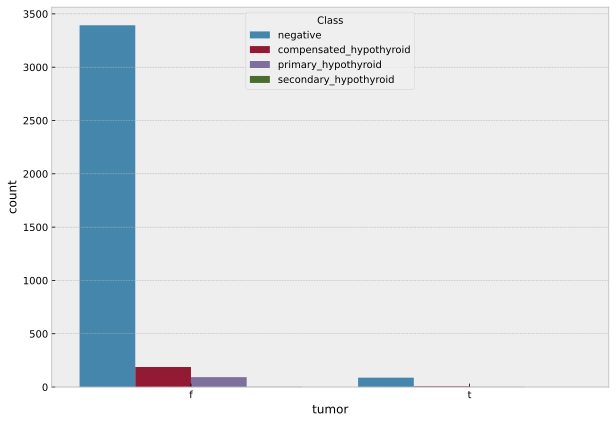

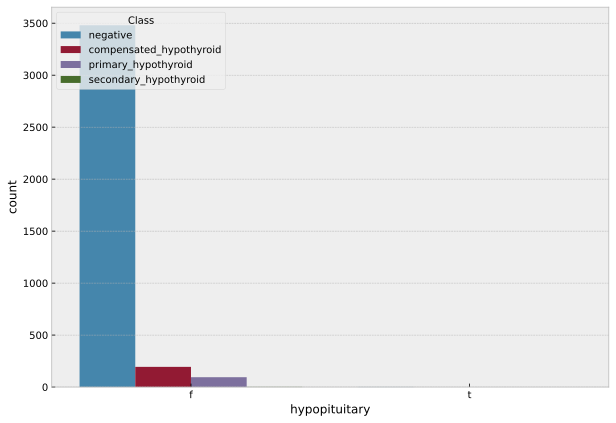

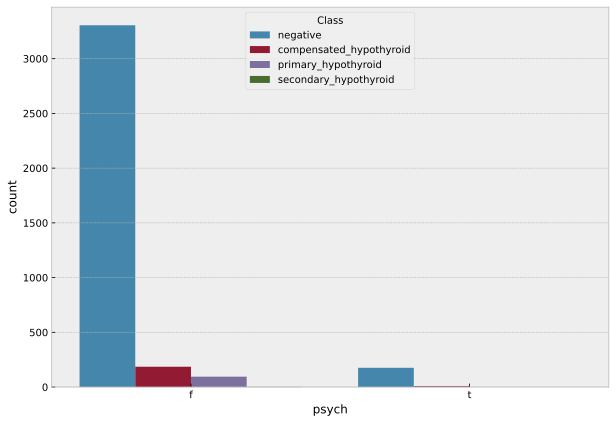

In [ ]:
for feature in categorical_features:
  sns.countplot(df[feature], hue=df['Class'])
  plt.show()

I don't see here any noticeable information.

Let's look at the target.

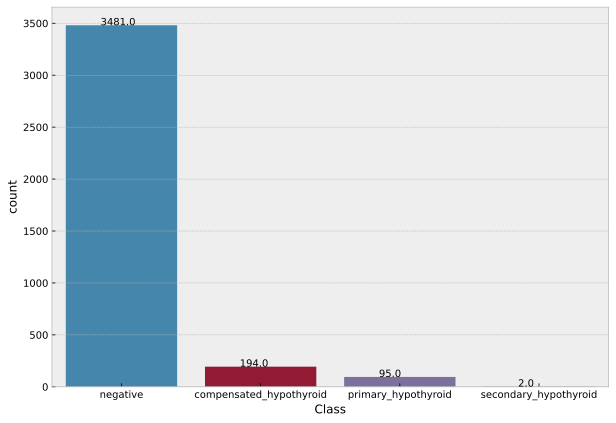

In [ ]:
ax = sns.countplot(x="Class", data=df)

for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.05))

plt.show()

We can see most of observations have `negative` target value. `secondary_hypothyroid` has only two observations.

##Handling missing values

Let's go back to the missing values.

In [ ]:
df.isna().sum()

age                            2
sex                          150
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
sick                           0
pregnant                       0
thyroid_surgery                0
I131_treatment                 0
query_hypothyroid              0
query_hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH                          369
T3                           769
TT4                          231
T4U                          387
FTI                          385
Class                          0
dtype: int64

The `sex` feature has 150 missing values. We can check if there are any observations with `pregnant` == True among records with missing gender.

In [ ]:
df[((df.sex.isnull()) & (df.pregnant == 't'))]

age  sex on_thyroxine query_on_thyroxine on_antithyroid_medication  \
1609  73.0  NaN            f                  f                         f   
3271  21.0  NaN            f                  f                         f   

     sick pregnant thyroid_surgery I131_treatment query_hypothyroid  ...  \
1609    f        t               f              f                 f  ...   
3271    f        t               f              f                 f  ...   

     goitre tumor hypopituitary psych  TSH   T3    TT4   T4U    FTI     Class  
1609      f     f             f     f  2.2  2.5  110.0  1.28   85.0  negative  
3271      f     t             f     f  2.4  3.5  171.0  1.49  115.0  negative  

[2 rows x 22 columns]

Well, according to public sources, the oldest mother in the world gave birth to twin girls at the age of 73 so we'll assume these records as correct and set the `sex` as 'F'.

In [ ]:
df['sex'] = np.where((df.sex.isnull()) & (df.pregnant == 't'), 'F', df.sex)

Now I'm interested in elderly and pregnant women.

In [ ]:
df[(df.pregnant == 't') & (df.age > 73)]

age sex on_thyroxine query_on_thyroxine on_antithyroid_medication sick  \
2223  75.0   F            f                  f                         f    f   

     pregnant thyroid_surgery I131_treatment query_hypothyroid  ... goitre  \
2223        t               f              f                 f  ...      f   

     tumor hypopituitary psych   TSH   T3    TT4   T4U   FTI     Class  
2223     f             f     f  0.46  2.9  139.0  1.53  91.0  negative  

[1 rows x 22 columns]

I'll remove this row.

In [ ]:
df.drop(df[(df.pregnant == 't') & (df.age > 73)].index, inplace=True)

I'd like to check if there are records with a lot of missing values.

In [ ]:
df[df.isnull().sum(axis=1) > 3]

age sex on_thyroxine query_on_thyroxine on_antithyroid_medication sick  \
39    64.0   F            f                  f                         f    f   
54    53.0   F            f                  f                         f    f   
66    69.0   F            f                  f                         f    f   
72    59.0   F            f                  f                         f    t   
92    26.0   F            f                  f                         f    f   
...    ...  ..          ...                ...                       ...  ...   
3707  51.0   F            f                  f                         f    f   
3745  59.0   F            f                  f                         f    f   
3752  71.0   F            f                  f                         f    f   
3763  41.0   F            f                  f                         f    f   
3767  30.0   F            f                  f                         f    f   

     pregnant thyroid_surgery I131_treatment query_hypothyroid  ... goitre  \
39          f               f              f                 f  ...      f   
54          f               f              f                 f  ...      f   
66          f               f              f                 f  ...      f   
72          f               f              f                 f  ...      f   
92          f               f              f                 f  ...      f   
...       ...             ...            ...               ...  ...    ...   
3707        f               f              f                 f  ...      f   
3745        f               f              f                 f  ...      f   
3752        f               f              f                 f  ...      f   
3763        f               f              f                 f  ...      f   
3767        f               f              f                 f  ...      f   

     tumor hypopituitary psych TSH   T3  TT4  T4U  FTI     Class  
39       f             f     f NaN  NaN  NaN  NaN  NaN  negative  
54       t             f     f NaN  2.8  NaN  NaN  NaN  negative  
66       f             f     f NaN  NaN  NaN  NaN  NaN  negative  
72       f             f     f NaN  NaN  NaN  NaN  NaN  negative  
92       f             f     f NaN  NaN  NaN  NaN  NaN  negative  
...    ...           ...   ...  ..  ...  ...  ...  ...       ...  
3707     f             f     f NaN  NaN  NaN  NaN  NaN  negative  
3745     f             f     f NaN  NaN  NaN  NaN  NaN  negative  
3752     f             f     f NaN  NaN  NaN  NaN  NaN  negative  
3763     f             f     f NaN  NaN  NaN  NaN  NaN  negative  
3767     t             f     f NaN  NaN  NaN  NaN  NaN  negative  

[226 rows x 22 columns]

In order not to remove valuable information, I'd like to take a look at the crosstab built with these missing values and target classes.

In [ ]:
crosstab_missing = pd.crosstab(df.isnull().sum(axis=1) > 3, df["Class"])
crosstab_missing

Class  compensated_hypothyroid  negative  primary_hypothyroid  \
row_0                                                           
False                      193      3258                   92   
True                         1       222                    3   

Class  secondary_hypothyroid  
row_0                         
False                      2  
True                       0

I'll drop these rows as most of them have unmeasured hormone tests.

In [ ]:
df.drop(df[df.isnull().sum(axis=1) > 3].index, inplace=True)

Rest of missing values in hormone tests I'll impute using 'median' strategy since we have a lot of outliers.

In [ ]:
imputer = SimpleImputer(strategy='median')

missing_features = ['TSH', 'T3', 'TT4', 'T4U', 'FTI']
for feature in missing_features:
  df[feature] = imputer.fit_transform(df[[feature]])

Before dealing with missing values in `sex`, I'd like to make a statistical test and check if removing NaNs can affect the target. Let's formulate null hypothesis $H_0$: there is no difference between populations with known and unknown values of `sex`. And the alternative hypothesis $H_1$: there is a difference between populations with known and unknown values of `sex`. Let the significance level $α$ be equal to 0.05.

In order to compute the Chi-square test statistic, we need to construct a contingency table.

In [ ]:
crosstab_sex = pd.crosstab(df['sex'].isna(), df["Class"])
crosstab_sex

Class  compensated_hypothyroid  negative  primary_hypothyroid  \
sex                                                             
False                      187      3132                   89   
True                         6       126                    3   

Class  secondary_hypothyroid  
sex                           
False                      2  
True                       0

We can compute the chi-square statistic and `p-value` for the hypothesis test using `chi2_contingency` and passing our contingency table as a parameter.

In [ ]:
scipy.stats.chi2_contingency(crosstab_sex)

(0.4433070307042427,
 0.9311578926136914,
 3,
 array([[1.85650212e+02, 3.13392948e+03, 8.84964739e+01, 1.92383639e+00],
        [7.34978843e+00, 1.24070522e+02, 3.50352609e+00, 7.61636107e-02]]))

Since `p-value` (0.9311578926136914) is bigger than 0.05, therefore null hypothesis can be accepted. We can assume removing rows with NaN in `sex` doesn't affect the target.

In [ ]:
df.dropna(how='any',inplace=True)

##Feature encoding

Now we need to encode categorical features. Since all these features can take on two values, I'll use label encoding. I'll also encode the target variable to build a correlation using one-hot encoding.

In [ ]:
df_encoded = df.copy().reset_index(drop=True)

In [ ]:
le = LabelEncoder()
ohe = OneHotEncoder()

for feature in categorical_features:
  df_encoded[feature] = le.fit_transform(df_encoded[feature])

transformer = make_column_transformer(
    (OneHotEncoder(), ['Class']),
    remainder='passthrough')

transformed = transformer.fit_transform(df_encoded)
df_encoded = pd.DataFrame(transformed, columns=transformer.get_feature_names())

In [ ]:
df_encoded.head().T

0       1       2       3  \
onehotencoder__x0_compensated_hypothyroid    0.00    0.00    0.00    0.00   
onehotencoder__x0_negative                   1.00    1.00    1.00    1.00   
onehotencoder__x0_primary_hypothyroid        0.00    0.00    0.00    0.00   
onehotencoder__x0_secondary_hypothyroid      0.00    0.00    0.00    0.00   
age                                         41.00   23.00   46.00   70.00   
sex                                          0.00    0.00    1.00    0.00   
on_thyroxine                                 0.00    0.00    0.00    1.00   
query_on_thyroxine                           0.00    0.00    0.00    0.00   
on_antithyroid_medication                    0.00    0.00    0.00    0.00   
sick                                         0.00    0.00    0.00    0.00   
pregnant                                     0.00    0.00    0.00    0.00   
thyroid_surgery                              0.00    0.00    0.00    0.00   
I131_treatment                               0.00    0.00    0.00    0.00   
query_hypothyroid                            0.00    0.00    0.00    0.00   
query_hyperthyroid                           0.00    0.00    0.00    0.00   
lithium                                      0.00    0.00    0.00    0.00   
goitre                                       0.00    0.00    0.00    0.00   
tumor                                        0.00    0.00    0.00    0.00   
hypopituitary                                0.00    0.00    0.00    0.00   
psych                                        0.00    0.00    0.00    0.00   
TSH                                          1.30    4.10    0.98    0.16   
T3                                           2.50    2.00    2.00    1.90   
TT4                                        125.00  102.00  109.00  175.00   
T4U                                          1.14    0.98    0.91    0.98   
FTI                                        109.00  107.00  120.00  107.00   

                                               4  
onehotencoder__x0_compensated_hypothyroid   0.00  
onehotencoder__x0_negative                  1.00  
onehotencoder__x0_primary_hypothyroid       0.00  
onehotencoder__x0_secondary_hypothyroid     0.00  
age                                        70.00  
sex                                         0.00  
on_thyroxine                                0.00  
query_on_thyroxine                          0.00  
on_antithyroid_medication                   0.00  
sick                                        0.00  
pregnant                                    0.00  
thyroid_surgery                             0.00  
I131_treatment                              0.00  
query_hypothyroid                           0.00  
query_hyperthyroid                          0.00  
lithium                                     0.00  
goitre                                      0.00  
tumor                                       0.00  
hypopituitary                               0.00  
psych                                       0.00  
TSH                                         0.72  
T3                                          1.20  
TT4                                        61.00  
T4U                                         0.87  
FTI                                        70.00

In [ ]:
for feature in df_encoded:
  df_encoded[feature] = df_encoded[feature].astype(float)

##Correlation

Now we can get the correlation.

In [ ]:
corr = df_encoded.corr()

Text(0.5, 1.0, 'Correlation')

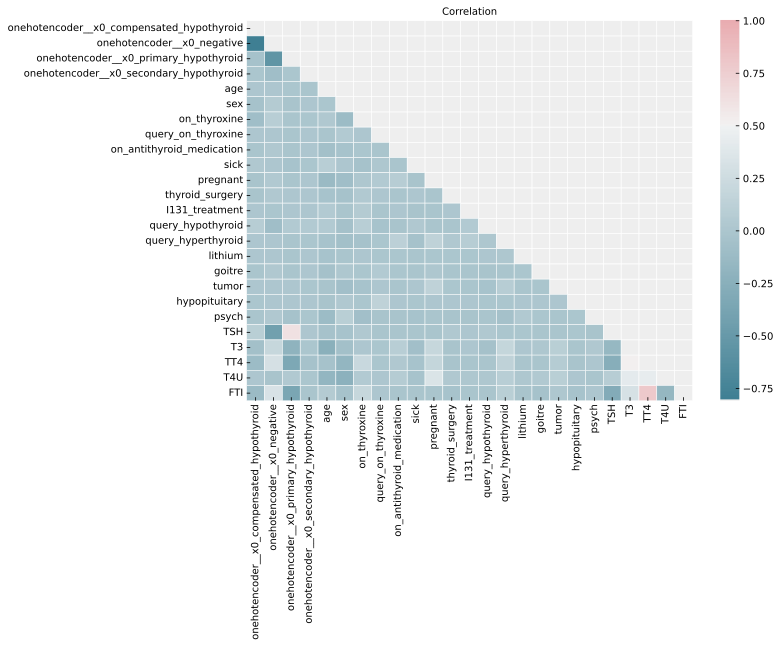

In [ ]:
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr,
            mask=mask,
            cmap=cmap,
            vmax=1,
            center=0.5,
            linewidths=.5,
            annot=False
           )
plt.title("Correlation", fontsize =10)

We can see, apparently, there is a negative correlation between `negative` target and other target values. Negative target value has also correlation with `TSH`. `primary_hypotheroid` might have correlation with `FTI` and `TT4`. We might also have a multicollinearity between `TT4` and `FTI`.

#X and y datasets

Now let's define train and test datasets.

In [ ]:
X = df_encoded.drop(['onehotencoder__x0_compensated_hypothyroid', 'onehotencoder__x0_negative', 'onehotencoder__x0_primary_hypothyroid', 'onehotencoder__x0_secondary_hypothyroid'], axis=1)
y = df[['Class']].reset_index(drop=True)
y = pd.DataFrame(le.fit_transform(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

We split our data so that all the classes are present in both datasets.

In [ ]:
y_train.value_counts()

1    2338
0     147
2      70
3       1
dtype: int64

In [ ]:
y_test.value_counts()

1    792
0     40
2     19
3      1
dtype: int64

I'll use `RobustScaler` for scaling our data since we have a lot of outliers.

In [ ]:
scaler = RobustScaler()

X_train_scaled = X_train.copy().reset_index(drop=True)
X_test_scaled = X_test.copy().reset_index(drop=True)

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

scaler.fit(X_test_scaled[numeric_features])
X_train_scaled[numeric_features] = pd.DataFrame(scaler.transform(X_train_scaled[numeric_features]))
X_test_scaled[numeric_features] = pd.DataFrame(scaler.transform(X_test_scaled[numeric_features]))

I'd like also make datasets with only three classes for future work.

In [ ]:
indexes_train = y_train[y_train[0] == 3].index
indexes_test = y_test[y_test[0] == 3].index

y_train_three_classes = y_train.drop(indexes_train)
y_test_three_classes = y_test.drop(indexes_test)

X_train_scaled_three_classes = X_train_scaled.drop(indexes_train)
X_test_scaled_three_classes = X_test_scaled.drop(indexes_test)

#Models comparison

Let's try different models on our data.

In [ ]:
models = {
    LogisticRegression():'Logistic Regression',
    SVC():"Support Vector Machine",
    RandomForestClassifier():'Random Forest',
    KNeighborsClassifier():'K Neighbors'
}
for m in models.keys():
    m.fit(X_train_scaled,y_train)
for model,name in models.items():
     print(f"Accuracy Score for {name} is : ",model.score(X_test_scaled,y_test)*100,"%")

Accuracy Score for Logistic Regression is :  95.4225352112676 %
Accuracy Score for Support Vector Machine is :  96.59624413145539 %
Accuracy Score for Random Forest is :  99.53051643192488 %
Accuracy Score for K Neighbors is :  97.1830985915493 %


The accuracy of all models is bigger than 95%. Hovewer, we can't make conclusions based on this metric since our dataset is very unbalanced. Therefore, we'll use `classification_report` method to look at precision, recall and f1-score.

In [ ]:
for model,name in models.items():
    y_pred = model.predict(X_test_scaled)
    print(f"Classification Report for {name}")
    print("----------------------------------------------------------")
    print(classification_report(y_test,y_pred))
    print("----------------------------------------------------------")

Classification Report for Logistic Regression
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.23      0.34        40
           1       0.96      1.00      0.98       792
           2       0.88      0.74      0.80        19
           3       0.00      0.00      0.00         1

    accuracy                           0.95       852
   macro avg       0.63      0.49      0.53       852
weighted avg       0.94      0.95      0.94       852

----------------------------------------------------------
Classification Report for Support Vector Machine
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.62      0.65        40
           1       0.98      0.99      0.98       792
           2       0.94      0.79      0.86        19
           3       0.00      0.00      0.00         1

    accuracy         

It seems that Random Forest gives the best results. None of the models predicted the class 3 correctly. This is obvious because we only have two observations for this class - one in the train dataset and one in the test. All the models predict the class 1 (`negative`) quite good since the dataset contains enough observations for this class.

#Random forest

Hereafter, I'll use two functions for building and evaluating models: `build_model_with_cv` and `print_results` respectively.

##Initial dataset

In [ ]:
rf_init = RandomForestClassifier()
cv_score = build_model_with_cv(rf_init, X_train_scaled, y_train, X_test_scaled, y_test, 5)

1 of KFold 5
F1 weighted score: 0.9951508620689655
2 of KFold 5
F1 weighted score: 0.9980585906397512
3 of KFold 5
F1 weighted score: 0.9980757468100823
4 of KFold 5
F1 weighted score: 1.0
5 of KFold 5
F1 weighted score: 0.9902379279263787


Cv: [0.9951508620689655, 0.9980585906397512, 0.9980757468100823, 1.0, 0.9902379279263787] 
Mean cv Score: 0.9963046254890356


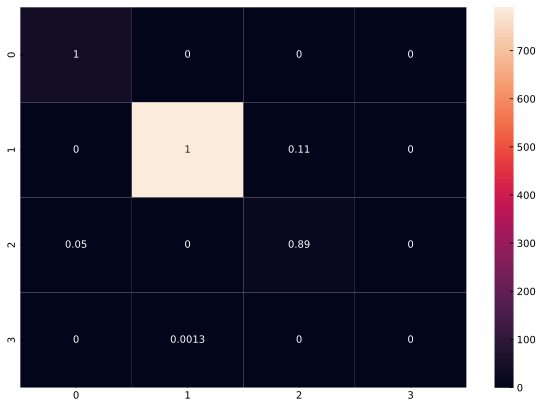

Score: 0.994131455399061
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        40
           1       1.00      1.00      1.00       792
           2       0.89      0.89      0.89        19
           3       0.00      0.00      0.00         1

    accuracy                           0.99       852
   macro avg       0.71      0.72      0.72       852
weighted avg       0.99      0.99      0.99       852



In [ ]:
print_results(rf_init, X_test_scaled, y_test, cv_score)

Random forest helps us understand which features are important.

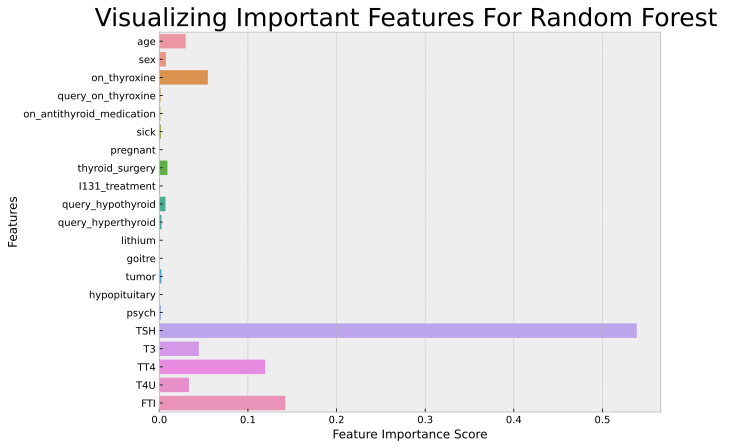

In [ ]:
plt.figure(figsize=(9,7))
feature_imp1 = rf_init.feature_importances_
sns.barplot(x=feature_imp1, y=X.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features For Random Forest ",{'fontsize':25})
plt.show();

We can see confirmation that hormone tests have the most impact on target. Now we can make new datasets using the most important features.

##Reduced dataset

In [ ]:
important_features = ['age', 'sex', 'on_thyroxine', 'thyroid_surgery', 'query_hypothyroid', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']

X_train_scaled_reduced = X_train_scaled[important_features]
X_test_scaled_reduced = X_test_scaled[important_features]

Now we can build a model using reduced dataset.

In [ ]:
rf_reduced = RandomForestClassifier()
cv_score = build_model_with_cv(rf_reduced, X_train_scaled_reduced, y_train, X_test_scaled_reduced, y_test, 5)

1 of KFold 5
F1 weighted score: 0.9951508620689655
2 of KFold 5
F1 weighted score: 0.9980585906397512
3 of KFold 5
F1 weighted score: 0.9980757468100823
4 of KFold 5
F1 weighted score: 1.0
5 of KFold 5
F1 weighted score: 0.9941880863831103


Cv: [0.9951508620689655, 0.9980585906397512, 0.9980757468100823, 1.0, 0.9941880863831103] 
Mean cv Score: 0.9970946571803818


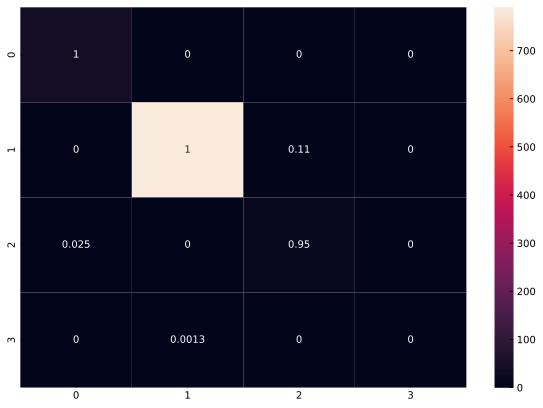

Score: 0.9953051643192489
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        40
           1       1.00      1.00      1.00       792
           2       0.90      0.95      0.92        19
           3       0.00      0.00      0.00         1

    accuracy                           1.00       852
   macro avg       0.72      0.74      0.73       852
weighted avg       0.99      1.00      0.99       852



In [ ]:
print_results(rf_reduced, X_test_scaled_reduced, y_test, cv_score)

The results became a little better.

#Logistic Regression

We can perform Grid Search in order to tune the hyperparameters. Since our data is imbalanced, we'll use `f1_weighted` as a scorer.

In [ ]:
lr = LogisticRegression(class_weight='balanced')
param = {'C':[0.001,0.003,0.005,0.01,0.03,0.05,0.1,0.3,0.5,1,2,3,3,4,5,10,20]}
grid_search(lr, param, 10, X_train_scaled_three_classes, y_train_three_classes)

Best f1: 0.9745324514090912, with best: {'C': 10}


So, we'll set the logistic regression parameter C to 10.

##Initial dataset

In [ ]:
lr_init = LogisticRegression(C=10)
cv_score = build_model_with_cv(lr_init, X_train_scaled, y_train, X_test_scaled, y_test, 5)

1 of KFold 5
F1 weighted score: 0.9537704693934678
2 of KFold 5
F1 weighted score: 0.9684894553003064
3 of KFold 5
F1 weighted score: 0.9752655380652014
4 of KFold 5
F1 weighted score: 0.9522831205793444
5 of KFold 5
F1 weighted score: 0.9598672273387852


Cv: [0.9537704693934678, 0.9684894553003064, 0.9752655380652014, 0.9522831205793444, 0.9598672273387852] 
Mean cv Score: 0.9619351621354209


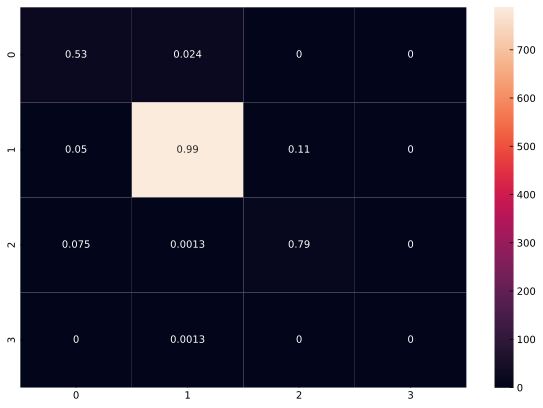

Score: 0.9671361502347418
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.53      0.64        40
           1       0.97      0.99      0.98       792
           2       0.88      0.79      0.83        19
           3       0.00      0.00      0.00         1

    accuracy                           0.97       852
   macro avg       0.67      0.58      0.61       852
weighted avg       0.96      0.97      0.96       852



In [ ]:
print_results(lr_init, X_test_scaled, y_test, cv_score)

Recall shows there is a high number of false-negative results for the class 0 (`compensated_hypothyroid`). This is a big problem because false-negative results pose greater risks.

We can look at the coefficients of logistic regression model to see what features have bigger importance.

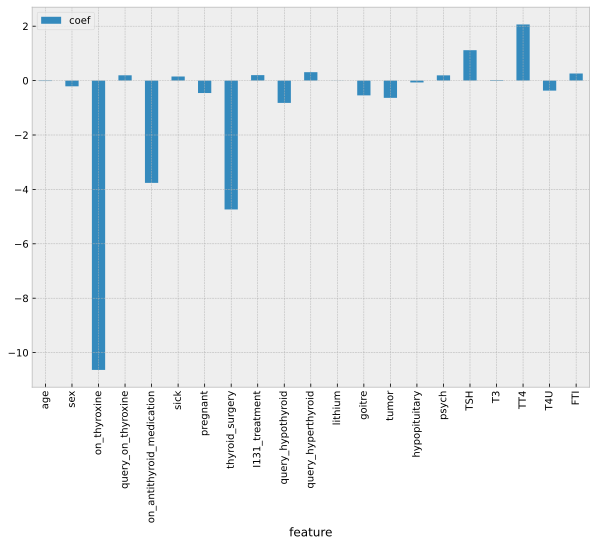

In [ ]:
importance = pd.DataFrame((lr_init.feature_names_in_, lr_init.coef_[0]), index = ['feature', 'coef']).transpose()
importance.plot.bar(x='feature')

##Dataset reduced with lr coefs

Let's create a new model using the features with the largest absolute coefficients.

In [ ]:
important_features_lr = ['on_thyroxine', 'on_antithyroid_medication', 'thyroid_surgery', 'TSH', 'TT4']

X_train_scaled_reduced_lr = X_train_scaled[important_features_lr]
X_test_scaled_reduced_lr = X_test_scaled[important_features_lr]

In [ ]:
lr_reduced_lr = LogisticRegression(C=10)
cv_score = build_model_with_cv(lr_reduced_lr, X_train_scaled_reduced_lr, y_train, X_test_scaled_reduced_lr, y_test, 5)

1 of KFold 5
F1 weighted score: 0.948559035978586
2 of KFold 5
F1 weighted score: 0.9653562362303536
3 of KFold 5
F1 weighted score: 0.9658397346569373
4 of KFold 5
F1 weighted score: 0.9522575009781006
5 of KFold 5
F1 weighted score: 0.9609339984196228


Cv: [0.948559035978586, 0.9653562362303536, 0.9658397346569373, 0.9522575009781006, 0.9609339984196228] 
Mean cv Score: 0.9585893012527201


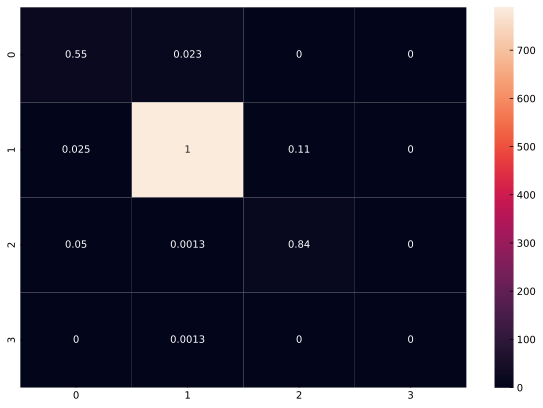

Score: 0.9706572769953051
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.55      0.68        40
           1       0.98      1.00      0.99       792
           2       0.89      0.84      0.86        19
           3       0.00      0.00      0.00         1

    accuracy                           0.97       852
   macro avg       0.69      0.60      0.63       852
weighted avg       0.97      0.97      0.97       852



In [ ]:
print_results(lr_reduced_lr, X_test_scaled_reduced_lr, y_test, cv_score)

##Dataset reduced with Random Forest

In [ ]:
lr_reduced_rf = LogisticRegression(C=10)
cv_score = build_model_with_cv(lr_reduced_rf, X_train_scaled_reduced, y_train, X_test_scaled_reduced, y_test, 5)

1 of KFold 5
F1 weighted score: 0.9563920134856492
2 of KFold 5
F1 weighted score: 0.9704725075312535
3 of KFold 5
F1 weighted score: 0.9658397346569373
4 of KFold 5
F1 weighted score: 0.9493967568797149
5 of KFold 5
F1 weighted score: 0.9605424096306218


Cv: [0.9563920134856492, 0.9704725075312535, 0.9658397346569373, 0.9493967568797149, 0.9605424096306218] 
Mean cv Score: 0.9605286844368355


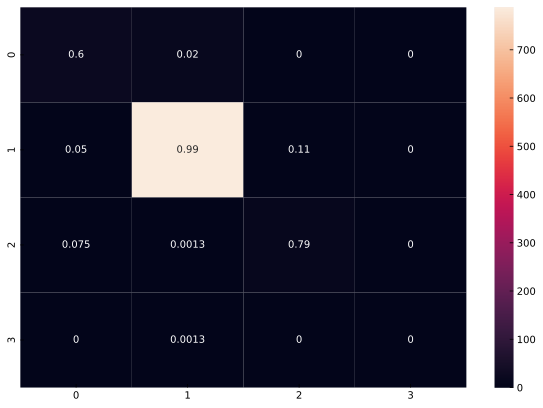

Score: 0.9706572769953051
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.60      0.70        40
           1       0.98      0.99      0.99       792
           2       0.88      0.79      0.83        19
           3       0.00      0.00      0.00         1

    accuracy                           0.97       852
   macro avg       0.67      0.60      0.63       852
weighted avg       0.97      0.97      0.97       852



In [ ]:
print_results(lr_reduced_rf, X_test_scaled_reduced, y_test, cv_score)

We can see the recall remains low. This can be because of very imbalanced dataset.

##Dataset after over-sampling

We can try to oversample our dataset using `BorderlineSMOTE`.

In [ ]:
smote = BorderlineSMOTE()
X_smote_reduced, y_smote_reduced = smote.fit_resample(X_train_scaled_reduced, y_train.to_numpy())

Let's check the results.

In [ ]:
y_smote_reduced = pd.DataFrame(y_smote_reduced)
y_smote_reduced.value_counts()

0    2338
1    2338
2    2338
3       1
dtype: int64

So, the number of instances in classes 0, 1 and 2 has become equal. However, the number of class 3 instances remains the same (1).

In [ ]:
lr_smote = LogisticRegression(C=10)
cv_score = build_model_with_cv(lr_smote, pd.DataFrame(X_smote_reduced), y_smote_reduced, X_test_scaled_reduced, y_test, 5)

1 of KFold 5
F1 weighted score: 0.9835845814363018
2 of KFold 5
F1 weighted score: 0.9792629817749273
3 of KFold 5
F1 weighted score: 0.9864529085079409
4 of KFold 5
F1 weighted score: 0.9893165479204495
5 of KFold 5
F1 weighted score: 0.983209962060932


Cv: [0.9835845814363018, 0.9792629817749273, 0.9864529085079409, 0.9893165479204495, 0.983209962060932] 
Mean cv Score: 0.9843653963401102


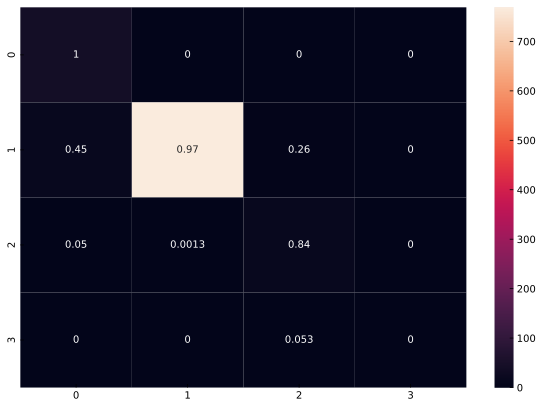

Score: 0.9683098591549296
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        40
           1       1.00      0.97      0.98       792
           2       0.73      0.84      0.78        19
           3       0.00      0.00      0.00         1

    accuracy                           0.97       852
   macro avg       0.60      0.70      0.64       852
weighted avg       0.98      0.97      0.97       852



In [ ]:
print_results(lr_smote, X_test_scaled_reduced, y_test, cv_score)

The recall values have increased. Now, the precision values became worse which means our classifier has a high number of False positives.

#K Neighbors

In [ ]:
X_train_scaled_reduced_three_classes = X_train_scaled_three_classes[important_features]

In [ ]:
knn = KNeighborsClassifier()
k_range = range(1, 31)
param = dict(n_neighbors=k_range)
grid_search(knn, param, 10, X_train_scaled_reduced_three_classes, y_train_three_classes)

Best f1: 0.9716490569655889, with best: {'n_neighbors': 3}


So, in our model, `n_neighbors` will be equal to 3.

##Dataset reduced with Random Forest

In [ ]:
knn_reduced_rf = KNeighborsClassifier(n_neighbors=3)
cv_score = build_model_with_cv(knn_reduced_rf, X_train_scaled_reduced, y_train, X_test_scaled_reduced, y_test, 5)

1 of KFold 5
F1 weighted score: 0.9682736234086282
2 of KFold 5
F1 weighted score: 0.9736886644963174
3 of KFold 5
F1 weighted score: 0.9676831430798496
4 of KFold 5
F1 weighted score: 0.9684264429399358
5 of KFold 5
F1 weighted score: 0.9578729460140072


Cv: [0.9682736234086282, 0.9736886644963174, 0.9676831430798496, 0.9684264429399358, 0.9578729460140072] 
Mean cv Score: 0.9671889639877478


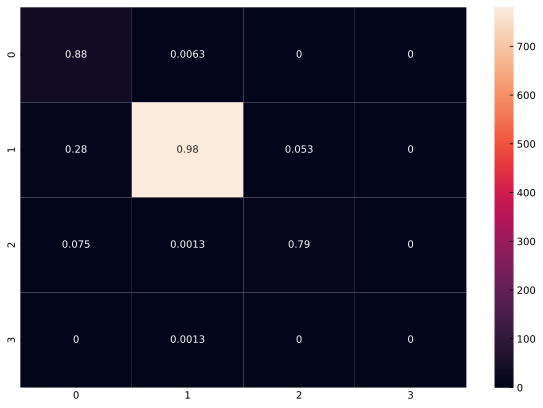

Score: 0.9741784037558685
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.88      0.79        40
           1       0.99      0.98      0.99       792
           2       0.94      0.79      0.86        19
           3       0.00      0.00      0.00         1

    accuracy                           0.97       852
   macro avg       0.66      0.66      0.66       852
weighted avg       0.98      0.97      0.97       852



In [ ]:
print_results(knn_reduced_rf, X_test_scaled_reduced, y_test, cv_score)

##Dataset after over-sampling

In [ ]:
knn_smote = KNeighborsClassifier(n_neighbors=3)
cv_score = build_model_with_cv(knn_smote, pd.DataFrame(X_smote_reduced), pd.DataFrame(y_smote_reduced), X_test_scaled_reduced, y_test, 5)

1 of KFold 5
F1 weighted score: 0.9828919327178043
2 of KFold 5
F1 weighted score: 0.987890642070224
3 of KFold 5
F1 weighted score: 0.9864564016189645
4 of KFold 5
F1 weighted score: 0.9914461950138954
5 of KFold 5
F1 weighted score: 0.9860885478035115


Cv: [0.9828919327178043, 0.987890642070224, 0.9864564016189645, 0.9914461950138954, 0.9860885478035115] 
Mean cv Score: 0.98695474384488


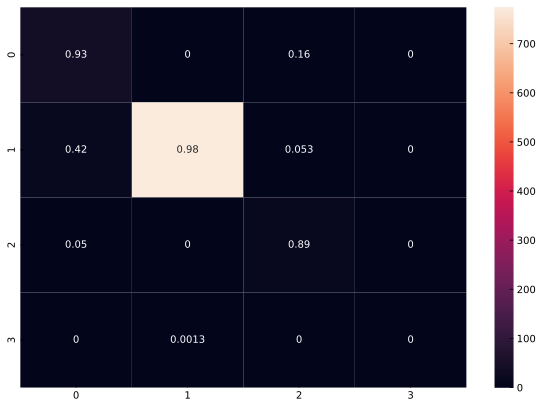

Score: 0.971830985915493
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.93      0.77        40
           1       1.00      0.98      0.99       792
           2       0.81      0.89      0.85        19
           3       0.00      0.00      0.00         1

    accuracy                           0.97       852
   macro avg       0.62      0.70      0.65       852
weighted avg       0.98      0.97      0.97       852



In [ ]:
print_results(knn_smote, X_test_scaled_reduced, y_test, cv_score)

We can say that oversampling helped to increase the recall values in classes 0 and 2. Hovewer, the precision is lower in this case.